In [2]:
import pandas as pd
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./human+activity+recognition+using+smartphones/UCI HAR Dataset/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./human+activity+recognition+using+smartphones/UCI HAR Dataset/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./human+activity+recognition+using+smartphones/UCI HAR Dataset/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human+activity+recognition+using+smartphones/UCI HAR Dataset/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./human+activity+recognition+using+smartphones/UCI HAR Dataset/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset( )을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

print("## 학습 피처 데이터 정보 ##")
print(X_train.info())

## 학습 피처 데이터 정보 ##
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [10]:
def evaluate_classifier_performance(classifier, X_test, y_test):
    # 예측 수행
    y_pred = classifier.predict(X_test)

    # 혼동 행렬 생성
    cm = confusion_matrix(y_test, y_pred)
    
    # 분류 보고서 생성
    report = classification_report(y_test, y_pred)

    # 혼동 행렬 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classifier.classes_, yticklabels=classifier.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # 분류 보고서 출력
    print("Classification Report:\n", report)

In [5]:
# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train , y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9253


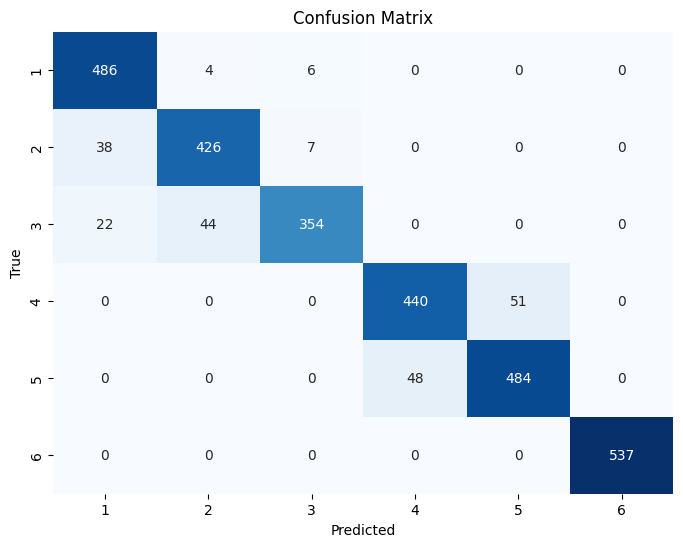

Classification Report:
               precision    recall  f1-score   support

           1       0.89      0.98      0.93       496
           2       0.90      0.90      0.90       471
           3       0.96      0.84      0.90       420
           4       0.90      0.90      0.90       491
           5       0.90      0.91      0.91       532
           6       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.92      0.92      2947
weighted avg       0.93      0.93      0.93      2947



In [11]:
# 랜덤 포레스트 모델에 대한 성능 평가 함수 호출
evaluate_classifier_performance(rf_clf, X_test, y_test)

In [13]:
from sklearn.svm import SVC
svc_clf = SVC()
svc_clf.fit(X_train, y_train)
pred2 = svc_clf.predict(X_test)
accuracy2 = accuracy_score(y_test, pred2)
print("SVC 정확도:", accuracy2)

SVC 정확도: 0.9504580929759077


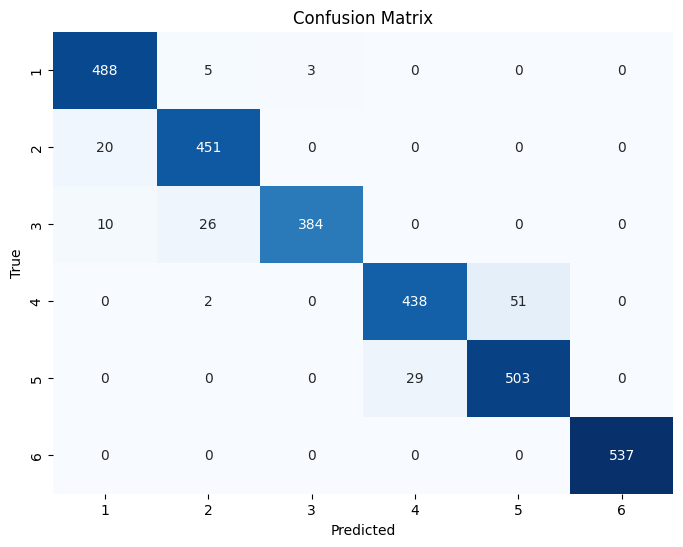

Classification Report:
               precision    recall  f1-score   support

           1       0.94      0.98      0.96       496
           2       0.93      0.96      0.94       471
           3       0.99      0.91      0.95       420
           4       0.94      0.89      0.91       491
           5       0.91      0.95      0.93       532
           6       1.00      1.00      1.00       537

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



In [14]:
evaluate_classifier_performance(svc_clf, X_test, y_test)

In [15]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
pred3 = dt_clf.predict(X_test)
accuracy3 = accuracy_score(y_test, pred3)
print("DT 정확도:", accuracy3)

DT 정확도: 0.8608754665761792


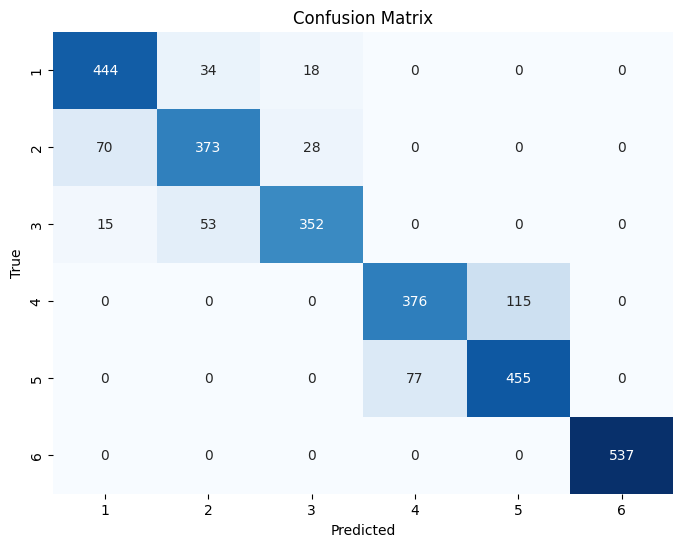

Classification Report:
               precision    recall  f1-score   support

           1       0.84      0.90      0.87       496
           2       0.81      0.79      0.80       471
           3       0.88      0.84      0.86       420
           4       0.83      0.77      0.80       491
           5       0.80      0.86      0.83       532
           6       1.00      1.00      1.00       537

    accuracy                           0.86      2947
   macro avg       0.86      0.86      0.86      2947
weighted avg       0.86      0.86      0.86      2947



In [16]:
evaluate_classifier_performance(dt_clf, X_test, y_test)

In [17]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred4 = lr_clf.predict(X_test)
accuracy4 = accuracy_score(y_test, pred4)
print("LR 정확도:", accuracy4)

LR 정확도: 0.9579233118425518


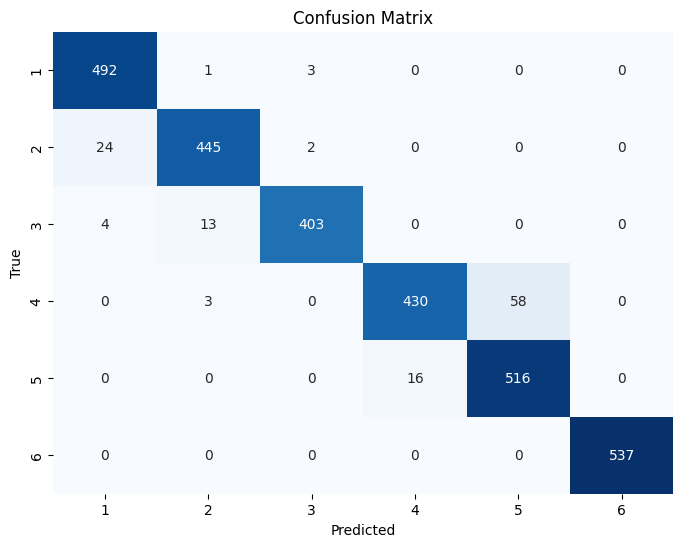

Classification Report:
               precision    recall  f1-score   support

           1       0.95      0.99      0.97       496
           2       0.96      0.94      0.95       471
           3       0.99      0.96      0.97       420
           4       0.96      0.88      0.92       491
           5       0.90      0.97      0.93       532
           6       1.00      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



In [18]:
evaluate_classifier_performance(lr_clf, X_test, y_test)

In [19]:
from sklearn.svm import LinearSVC
# Linear SVM 모델 생성
svm_clf = LinearSVC(random_state=0)

# 모델 학습
svm_clf.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_pred = svm_clf.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print('Linear SVM 정확도: {0:.4f}'.format(accuracy))

Linear SVM 정확도: 0.9661


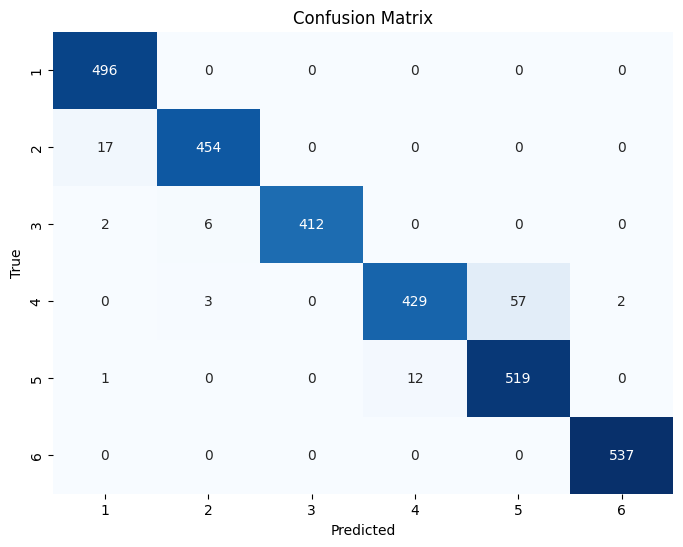

Classification Report:
               precision    recall  f1-score   support

           1       0.96      1.00      0.98       496
           2       0.98      0.96      0.97       471
           3       1.00      0.98      0.99       420
           4       0.97      0.87      0.92       491
           5       0.90      0.98      0.94       532
           6       1.00      1.00      1.00       537

    accuracy                           0.97      2947
   macro avg       0.97      0.97      0.97      2947
weighted avg       0.97      0.97      0.97      2947



In [20]:
evaluate_classifier_performance(svm_clf, X_test, y_test)